In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pickle
import sys

import cv2
import redis
import tensorflow as tf

sys.path.append("/home/jovyan/tensorflow-models/research")

from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util

/home/jovyan/tensorflow-models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib

In [2]:
PATH_TO_CKPT = "/home/jovyan/work/model/frozen_inference_graph.pb"
PATH_TO_LABELS = "/home/jovyan/tensorflow-models/research/object_detection/data/mscoco_label_map.pbtxt"         
NUM_CLASSES = 90

In [3]:
detection_graph = tf.Graph()                                                    
with detection_graph.as_default():                                              
    od_graph_def = tf.GraphDef()                                                
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:                             
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)                          
        tf.import_graph_def(od_graph_def, name='')                              
                                                                                
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)                        
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)               
                                                                                
sess = tf.Session(graph=detection_graph)

In [4]:
detection_graph = tf.Graph()                                                    
with detection_graph.as_default():                                              
    od_graph_def = tf.GraphDef()                                                
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:                             
        serialized_graph = fid.read()                                           
        od_graph_def.ParseFromString(serialized_graph)                          
        tf.import_graph_def(od_graph_def, name='')                              
                                                                                
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)                        
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)               
                                                                                
sess = tf.Session(graph=detection_graph)

In [5]:
ops = detection_graph.get_operations()                                             
all_tensor_names = {output.name for op in ops for output in op.outputs}            
tensor_dict = {}                                                                   
for key in [                                                                       
    'num_detections', 'detection_boxes', 'detection_scores',                       
    'detection_classes', 'detection_masks'                                         
]:                                                                                 
    tensor_name = key + ':0'                                                       
    if tensor_name in all_tensor_names:                                            
        tensor_dict[key] = detection_graph.get_tensor_by_name(tensor_name)         
if 'detection_masks' in tensor_dict:                                               
    # The following processing is only for single image                            
    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])              
    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])              
    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)       
    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(         
        detection_masks, detection_boxes, image.shape[0], image.shape[1])          
    detection_masks_reframed = tf.cast(                                            
        tf.greater(detection_masks_reframed, 0.5), tf.uint8)                       
    # Follow the convention by adding back the batch dimension                     
    tensor_dict['detection_masks'] = tf.expand_dims(                               
        detection_masks_reframed, 0)                                               
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')                       

In [6]:
def run_inference(sess, image):
   output_dict = sess.run(tensor_dict,                                             
                          feed_dict={image_tensor: np.expand_dims(image, 0)})   
                                                                                   
   # all outputs are float32 numpy arrays, so convert types as appropriate         
   output_dict['num_detections'] = int(output_dict['num_detections'][0])           
   output_dict['detection_classes'] = output_dict[                                 
       'detection_classes'][0].astype(np.uint8)                                    
   output_dict['detection_boxes'] = output_dict['detection_boxes'][0]              
   output_dict['detection_scores'] = output_dict['detection_scores'][0]            
   if 'detection_masks' in output_dict:                                            
       output_dict['detection_masks'] = output_dict['detection_masks'][0]          
   return output_dict                                    

dict_keys(['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'])


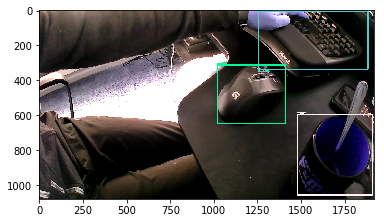

In [7]:
r = redis.StrictRedis(host='redis', port=6379, db=0)
frame = pickle.loads(r.get('img'))
output_dict = run_inference(sess, frame)      
vis_util.visualize_boxes_and_labels_on_image_array(                                
    frame,                                                                         
    output_dict['detection_boxes'],                                                
    output_dict['detection_classes'],                                              
    output_dict['detection_scores'],                                               
    category_index,                                                                
    instance_masks=output_dict.get('detection_masks'),                             
    use_normalized_coordinates=True,                                               
    line_thickness=8)
plt.imshow(frame)
print(tensor_dict.keys())

In [8]:
export_path = "/home/jovyan/work/exported/2"
builder = tf.saved_model.builder.SavedModelBuilder(export_path)

classification_inputs = tf.saved_model.utils.build_tensor_info(image_tensor)
serving_outputs = {}
for tn, t in tensor_dict.items():
    serving_outputs[tn] = tf.saved_model.utils.build_tensor_info(tensor_dict[tn])



classification_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={
              tf.saved_model.signature_constants.CLASSIFY_INPUTS:
                  classification_inputs
          },
          outputs=serving_outputs
      )
)


In [9]:
legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
              classification_signature,
      },
      legacy_init_op=legacy_init_op)

builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/home/jovyan/work/exported/2/saved_model.pb'


b'/home/jovyan/work/exported/2/saved_model.pb'